# Aprendizaje Supervisado con Scikit-Learn - Día 1

Antes que nada, vamos a comprobar las versiones de las diferentes librerías que vamos a estar utilizando a lo largo de las clases:

In [ ]:
import sys
print("Python version:", sys.version)

import pandas as pd
print("pandas version:", pd.__version__)

import matplotlib
print("matplotlib version:", matplotlib.__version__)

import numpy as np
print("NumPy version:", np.__version__)

import scipy as sp
print("SciPy version:", sp.__version__)

import IPython
print("IPython version:", IPython.__version__)

import sklearn
print("scikit-learn version:", sklearn.__version__)

Por último, vamos a desactivar los mensajes de advertencia *`DeprecationWarnings`*, ya que no afectan en nada al código ni nuestros objetivos formativos para las clases:

In [ ]:
# Importamos un filtro de warnings
from warnings import simplefilter
# Ignoramos los DeprecationWarnings, en concreto el del módulo six.py
simplefilter(action='ignore', category=DeprecationWarning)

In [ ]:
# Hacemos ciertas configuraciones iniciales
%matplotlib inline
from preamble import *

## Lab 0 - Datasets de ejemplo

Una de las mejores maneras de aprender es, en general, reducir la dimensionalidad de un problema hasta comprender las cuestiones básicas y desarrollar una *intuición*.

Ésta es una técnica muy utilizada en Ciencias Físicas, donde muchas veces se estudia un modelo unidimensional y luego se generaliza, con la ayuda de herramientas matemáticas, a $n$ dimensiones.

Aquí haremos lo mismo gracias a una serie de Datasets básicos que utilizaremos en conjunto con otros reales a lo largo del curso.

### Forge Dataset
Utilizaremos un dataset llamado *Forge* para algunos ejemplos de modelos de clasificación supervisada. He aquí el dataset:

In [ ]:
# Generamos un dataset
X, y = mglearn.datasets.make_forge() # Característica, Característica
# Lo pintamos
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.legend(["Clase 0", "Clase 1"], loc=4)
plt.xlabel("Caractística 1")
plt.ylabel("característica 2")

¿Cuántos datapoints y características tiene este Dataset $X$? Utiliza Numpy para saber la respuesta, apóyate en el método `type()` de Python si necesitas saber qué métodos puedes utilizar sobre él, así como la combinación `Tab` y `Shift-Tab` para conocer la documentación de los diferentes métodos disponibles:

In [ ]:
# Escribe la línea de código abajo
print("X.shape:", X.shape)

#### Dataset Wave

Utilizaremos otro dataset llamado *Wave* para los ejemplos básicos de regresión supervisada. Igualmente, utilizamos un dataset muy sencillo, de pocas dimensiones que nos ayude a visualizar y a desarrollar una intuición sobre nuestros modelos.

In [ ]:
# Generamos un dataset
X, y = mglearn.datasets.make_wave(n_samples=40) #Inputs, Outputs
plt.plot(X, y, 'o')
plt.ylim(-3, 3)
plt.xlabel("Característica")
plt.ylabel("Objetivo")

#### Un ejemplo real: Wisconsin Breast Cancer Dataset
Scikit-learn incluye algunos datasets reales con el propósito de trabajar con ellos de manera más sencilla. Éstos se almacenan como objetos `Bunch`. Lo único que es necesario saber de estos objetos por el momento es que se comportan como diccionarios de Python, con el beneficio añadido de que los valores se pueden acceder con *dot notation*.

In [ ]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
print("cancer.keys():\n", cancer.keys())

In [ ]:
type(cancer)

In [ ]:
print("Dimensiones del dataset:", cancer.data.shape)

Cada tumor está etiquetado como *benigno* o *maligno*, y el objetivo será aprender a predecir en base a ciertas características del tejido si un tumor es benigno o maligno.

In [ ]:
print("Conteo de muestras por clase:\n",
      {n: v for n, v in zip(cancer.target_names, np.bincount(cancer.target))})

Para obtener una descripción del significado de cada una de las características, podemos usar el atributo `feature_names`:

In [ ]:
print("Nombres de las características:\n", cancer.feature_names)

#### Otro ejemplo real: Boston Housing Dataset
El objetivo de este dataset es predecir el valor medio de las casas en varios barrios de Boston en la década de los '70 usando información como la tasa de criminalidad, proximidad al río Charles, acceso a autovías, etc.

In [ ]:
from sklearn.datasets import load_boston
boston = load_boston()
print("Data shape:", boston.data.shape)

A efectos de utilizar este dataset, es mejor complementarlo considerando no sólo las 13 características iniciales, sino todos los productos entre características (llamados también *interacciones*). La generación de interacciones la haremos incrementando el grado polinómico del dataset con el transformador de Scikit Learn [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) Además, modificaremos la escala de los datos para uniformizarla y poder utilizar el concepto de medida de los datos correctamente gracias al preprocesador [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) de Scikit-Learn.

El incluir características derivadas como estas se llama **Ingeniería de características**. El dataset ampliado puede cargarse gracias a la función `load_extended_boston`.

In [ ]:
# Definimos una función en Python para encapsular la ingeniería de características que vamos a realizar sobre el dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
def load_extended_boston():
    boston = load_boston()
    X = boston.data
    # Aplicamos un MinMaxScaler para escalar las características bajo un mismo criterio
    X = MinMaxScaler().fit_transform(boston.data)
    # Finalmente, generamos interacciones entre las diferentes características.
    X = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X)
    return X, boston.target

In [ ]:
X, y = load_extended_boston()
print("X.shape:", X.shape)

## Lab 1 - k-Nearest Neighbors
### Clasificación k-NN

Usemos para empezar nuestro dataset *Forge*. Primero, separamos los datos en un set de training y de test para poder evaluar el rendimiento del modelo:

In [1]:
import mglearn
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split
X, y = mglearn.datasets.make_forge()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

/Users/victormac/anaconda3/envs/ks-sl/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Lo siguiente es importar e instanciar la clase. Aquí es donde podemos poner un número de vecinos, por ejemplo, 3:

In [3]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)

Finalmente, entrenamos el modelo usando el juego de datos de entrenamiento. Esto implica almacenar el dataset para poder calcular los vecinos durante la predicción:

In [4]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [5]:
print("Predicciones sobre el juego de pruebas:", clf.predict(X_test))

Predicciones sobre el juego de pruebas: [1 0 1 0 1 0 0]


In [6]:
print("Precisión sobre el juego de pruebas: {:.2f}"
      .format(clf.score(X_test, y_test)))

Precisión sobre el juego de pruebas: 0.86


### Análisis de KNeighborsClassifier

Se puede ilustrar la predicción para todos los puntos en el plano $xy$. Se usan colores en el plano de acuero con la clase predicha para el punto en cuestión. Eso permite ver la frontera de decisión y desarrollar una cierta intuición sobre el modelo en función del número de vecinos.

En el siguiente código, se generan gráficas para valores de vecinos de 1, 3 y 9:

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for n_neighbors, ax in zip([1, 3, 9], axes):
    # the fit method returns the object self, so we can instantiate
    # and fit in one line
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)
    mglearn.plots.plot_2d_separator(
        clf, X, fill=True, eps=0.5, ax=ax, alpha=.4)
    mglearn.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title("{} vecino(s)".format(n_neighbors))
    ax.set_xlabel("característica 0")
    ax.set_ylabel("característica 1")
axes[0].legend(loc=3)

NameError: name 'plt' is not defined

**Pregunta**: ¿qué diferencias observas en la frontera de clasificación y qué puede decirse del uso de varios vecinos frente al uso de uno sólo?


Un sólo vecino hace que la frontera de decisión se ajuste mucho a los datos de entrenamiento. Si se incrementa el número de vecinos, la frontera se suaviza.
Esto implica que con un número bajo de vecinos, el modelo es más complejo, y con un número alto, menos. Yendo a un extremo, si $k=n$, donde n es el núermo de muestras del juego de entrenamiento, todos los puntos tendrían el mismo número de vecions y la predicción sería siempre la mism: la clase más frecuente en el juego de entrenamiento.

Vamos a evaluar ahora la conexión entre complejidad y generalización usando un dataset real (Breast Cancer Dataset):

In [ ]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target,
    stratify=cancer.target, random_state=66)

training_accuracy = []
test_accuracy = []
# Probamos n_neighbors de 1 a 10
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    # Construimos el modelo
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # Guardamos la precisión del training set
    training_accuracy.append(clf.score(X_train, y_train))
    # Guardamos la precisión de testing set (generalización)
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings,
         training_accuracy, label="precisión training")
plt.plot(neighbors_settings, test_accuracy, label="precisión test")
plt.ylabel("Precisión")
plt.xlabel("n_neighbors")
plt.legend()

¿Reconoces las características de las curvas  de complejidad frente a precisión que vimos al principio? (Nótese que por el eje de ordenadas, la curva correspondiente al training set está invertida)

**¿Qué numero de vecinos es el mejor para obtener el mejor rendimiento del modelo?**

Como puede verse en la gráfica, obtenemos el mejor rendimiento en test para k=6, lo que nos da también la precisión que obtenemos en el dataset de training.

### Regresión k-NN
También hay una variante de regresión de k-Nearest Neighbors. De nuevo, comparemos el uso de un solo vecino frente a tres para ver la variación de las predicciones:

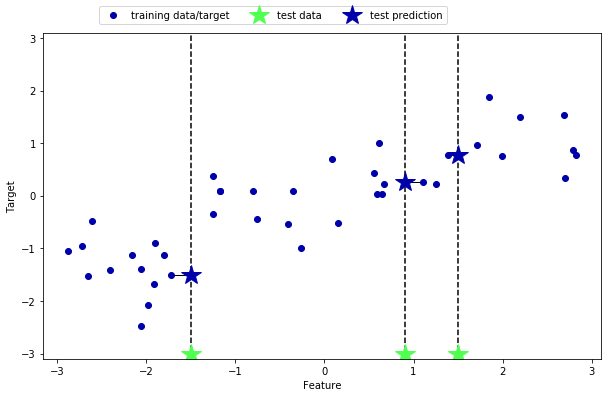

In [8]:
mglearn.plots.plot_knn_regression(n_neighbors=1)

In [ ]:
mglearn.plots.plot_knn_regression(n_neighbors=3)

La implementación de kNN para regresión en Scikit-learn es muy parecida a su equivalente de clasificación. Lo hacemos aquí para el *Wave* dataset:

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

X, y = mglearn.datasets.make_wave(n_samples=40)

# Partimos el dataset wave en training y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)

# Instanciamos el modelo y especificamos 3 vecinos
reg = KNeighborsRegressor(n_neighbors=3)
# Ajustamos el modelo usando los objetivo y datos de training
reg.fit(X_train, y_train)

In [ ]:
print("Predicciones sobre el test set:\n", reg.predict(X_test))

También podemos evaluar el modelo utilizando el método `score`, que para la regresión devuelve $R^2$ (el coeficiente de determinación, una medida de lo bueno que es un modelo de regresión que veremos en más detalle más adelante):

In [ ]:
print("Coeficiente de determinación del test set: {:.2f}".format(reg.score(X_test, y_test)))

### Análisis de KNeighborsRegressor

Para establecer el análisis, vamos a hacer una predicción de todos los posibles valores que puede tener la característica $x$ (donde $x\in[1,3000]$), y para ello creamos un dataset que tenga todos los puntos en una línea:

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# Crear 1,000 data points, igualmente espaciados entre -3 y 3
line = np.linspace(-3, 3, 1000).reshape(-1, 1)
for n_neighbors, ax in zip([1, 3, 9], axes):
    # make predictions using 1, 3, or 9 neighbors
    reg = KNeighborsRegressor(n_neighbors=n_neighbors)
    reg.fit(X_train, y_train)
    ax.plot(line, reg.predict(line))
    ax.plot(X_train, y_train, '^', c=mglearn.cm2(0), markersize=8)
    ax.plot(X_test, y_test, 'v', c=mglearn.cm2(1), markersize=8)

    ax.set_title(
        "{} vecinos(s)\n Train score: {:.2f} Test score: {:.2f}".format(
            n_neighbors, reg.score(X_train, y_train),
            reg.score(X_test, y_test)))
    ax.set_xlabel("Característica")
    ax.set_ylabel("Objetivo")
axes[0].legend(["Predición modelo", "Training data/objetivo",
                "Test data/objetivo"], loc="best")

Como ejercicio adicional con kNNs, ábrase el fichero [kNNs-Exercise.ipynb](kNNs-Exercise.ipynb).

# Aprendizaje Supervisado con Scikit-Learn - Día 2

## Lab 2 - Modelos lineales de regresión
\begin{align*}
\end{align*}
A continuación, se muestra el gráfico del ajuste por regresión lineal de los datos del dataset *Wave*.  Lo mostramos para adelantar la discusión teórica sobre el modelo, más abajo aprenderemos cómo entrenar modelos lineales.

w[0]: 0.393906  b: -0.031804


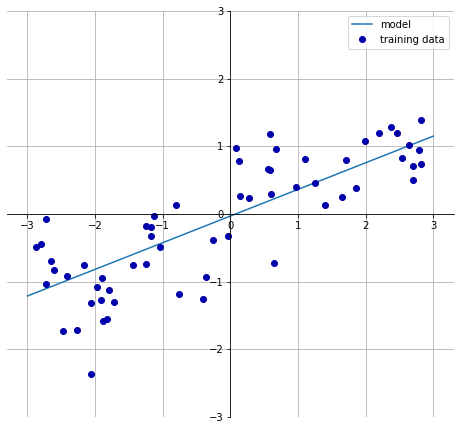

In [9]:
import mglearn
mglearn.plots.plot_linear_regression_wave()

Se puede ver que el corte de la línea coincide con $b$, y que la pendiente es $w_0$. Si se compara esta recta con lo que hemos pintado previamente para el regresor kNN, una línea parece una predicción demasiado restrictiva y que el detalle de los datos se pierde. En parte es cierto, y es una asunción muy fuerte el suponer que el objetivo es una combinación lineal de características.

Pero no nos dejemos engañar por la visión unidimensional del modelo. **Para datasets con muchas características** los modelos lineales pueden ser muy potentes.

Hay diferentes modelos lineales para la regresión. La diferencia está en:

  - cómo se aprenden $w$ y $b$ a partir de los datos de entrenamiento
  - cómo se controla la complejidad del modelo.

### Regresión lineal, alias Ordinary Least Squares (OLS)

La regresión lineal OLS es el método más simple y clásico de regresión lineal. Se trata de buscar los parámetros $w$ (también llamado pesos o coeficientes) y $b$ (también llamado *offset* o *intercept*) que minimicen el error cuadrático medio entre predicción y objetivo. No tiene más parámetros, que implica sencillez, pero también menos capacidad para controlar la complejidad del modelo.

Éste es el código que produce la gráfica que aparece más arriba:

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# Hacemos un dataset tipo wave con 60 muestras
X, y = mglearn.datasets.make_wave(n_samples=60)
# Hacemos el split, con un random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Por último, instanciamos y entrenamos el modelo
lr = LinearRegression().fit(X_train, y_train)

Scikit-learn almacena siempre los datos derivados del entrenamiento de un modelo en atributos que terminan en guión bajo. En este caso, podemos consultar los pesos y el corte a través de las variables `coef_` y `intercept_`:

In [ ]:
# Muestra ambas variables para el modelo que acabamos de entrenar
print("lr.coef_:", lr.coef_) #Así nos dice la pendiente de la recta
print("lr.intercept_:", lr.intercept_)

Echemos un vistazo al rendimiento en el training set y el test set a través de $R^{2}$:

In [ ]:
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
#No quiero ver 100%, el modelo tiene que generalizar bien
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))
#No son muy buenos datos, son un poco bajas y tiene pinta de ser un poco underfitting

El $R^2$ de test no es demasiado bueno, pero ambos se parecen.

Esto significa que probablemente estamos en una situación de *underfitting*. En este caso de regresión lineal, con una dimensión hay muy poco riesgo de hacer overfitting, ya que el modelo es muy restringido.

Con datasets con más características, los modelos lineales son más potentes,  y como consecuencia hay un mayor riesgo de incurrir en *overfitting*. 

**Ejercicio**

Veamos cómo se comporta OLS sobre un dataset como Boston Housing, que tiene mayor dimensionalidad (106 características). La manera de hacerlo es igual que en una dimensión:

In [ ]:
from sklearn.datasets import load_boston
# Cargamos el dataset con la herramienta de carga de Scikit-Learn
X, y = mglearn.datasets.load_extended_boston()


In [ ]:
# Creamos datasets de entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
#el random state es como un seed, solo para que a todos nos salga lo mismo, en la realidad no lo usaremos

# Entrenamos el modelo
lr = LinearRegression().fit(X_train, y_train)

Ahora mostramos el score:

In [ ]:
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))
# Con más datos nos salen mejores scores, pero ojo" es muy alta el training y más baja en el Test
# Es probable que estemos haciendo overfitting
# Podríamos introducir parámetros para dar más pesos a determinadas características: es lo que hace Ridge

$R^2$ es ahora bueno en el training set, pero mucho peor en el test set.

La discrepancia en el valor de $R^2$ es una señal clara de que hay *overfitting*. Deberíamos buscar un modelo que nos permita algo de control sobre la complejidad.

### Regresión contraída, de Tikhonov, o *Ridge*

La regresión *Ridge* usa la misma fórmula que OLS, pero los coeficientes $w$ se eligen de forma que se ajusten a una limitación adicional más allá de ajustarse a los datos.

Se persigue además que los diferentes $w_i$ sean lo más pequeños posible.

**Pregunta: ¿qué puede significar esto intuitivamente?**

Esto significa que cada característica debería tener el menor peso posible sobre el resultado final, que se traduce en una pendiente menor a la vez que ajustándose para hacer una predicción.

Esta técnica es un ejemplo de lo que se llama en ML **Regularización**, que es justamente restringir un modelo para evitar el *overfitting*. En particular, *Ridge* realiza una regularización de norma 2 ($L2$).

Veamos cómo funciona en el dataset Boston Housing con Scikit-Learn:

In [ ]:
#Es una regresión lineal pero introduciendo un grado de control, regulación L2,
# que lo hace es cargarse los pesos que son pequeños y dar más protagonismo a pesos grandes

from sklearn.linear_model import Ridge

ridge = Ridge().fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))
#Como se ve es mejor el Test, aunque baje un poco el Train, generalizamos mejor entonces
# Como en este dataset teníamos muchas caracteristicas,
# este tipo es mejor, porque el modelo es menos complejo 

**Discutimos los resultados**

Vemos que $R^2$ para el training set es más bajo que OLS, mientras que para test es más alto, lo cual es consistente con lo que estábamos esperando ya que antes teníamos una situación de sobreajuste. 

Ridge es un modelo más constreñido, así que tenemos menos posibilidad de sobreajuste. Aunque el rendimiento en el conjunto de aprendizaje sea peor, **generaliza mejor**.

El parámetro de control del modelo por el cual elegimos el balance entre simplicidad y rendimiento en el training set se llama ***alpha***. En el caso anterior se usaba el valor por defecto, $\alpha=1.0$.

El valor óptimo de $\alpha$ dependerá del dataset particular.

**Ejercicio: vuelve a entrenar un Rigde sobre Boston Housing, pasando un valor de alpha = 10, y muestra los valores de $R^2$ para training y test**

In [ ]:
ridge10 = Ridge(alpha=10).fit(X_train, y_train)
print("Training set score: {:.2f}".format(
    ridge10.score(X_train, y_train)))
print("Test set score: {:.2f}".format(
    ridge10.score(X_test, y_test)))

**Ejercicio: Haz lo mismo pasando un valor de alpha = 0.1, y muestra los valores de $R^2$ para training y test**

In [10]:
ridge01 = Ridge(alpha=0.1).fit(X_train, y_train)
print("Training set score: {:.2f}".format(
    ridge01.score(X_train, y_train)))
print("Test set score: {:.2f}".format(
    ridge01.score(X_test, y_test)))
# Si comparamos con el anterior, hemso conseguido un poco más de rendimiento
# (mejor en el Test, predice mejor) reduciendo el valor de alpha

NameError: name 'Ridge' is not defined

**Pregunta: ¿qué funciona mejor y cómo podríamos intentar mejorarlo?**

$\alpha=0.1$ funciona mejor, y podríamos intentar decrementar `alpha` aún algo más para ganar en generalización. Lo que se observa claramente es que el parámetro $\alpha$ tiene una correspondencia con la complejidad del modelo que hemos visto en la presentación. Métodos concretos para seleccionar el parámetro entrarían dentro del campo de la **evaluación y mejora de modelos**.

También podemos tener una visión cualitativa más amplia si inspeccionamos cómo cambian los coeficientes con el valor de `alpha`. Recordemos que en Scikit-learn tenemos el valor de estos coeficientes en el atributo `coef_`.

Pintamos en un gráfico los coeficientes para los tres valores de $\alpha$:

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ridge.coef_, 's', label="Ridge alpha=1")
plt.plot(ridge10.coef_, '^', label="Ridge alpha=10")
plt.plot(ridge01.coef_, 'v', label="Ridge alpha=0.1")

plt.plot(lr.coef_, 'o', label="OLR")
plt.xlabel("Indice coef.")
plt.ylabel("Magnitud coef.")
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.ylim(-25, 25)
plt.legend()
# A mayor alpha más cercan están de la línea,
# dando aun más peso a determinadas carecterísticas respecto a los otros alphas
# Teniendo alpha muy alto es más restringido y nos podemos cargar la predicción

**Discusión**

El eje $x$ tiene las componentes del vector de coeficientes ($x=0$ es $w_0$, $x=100$ es $w_100$), y el eje $y$ tiene el valor numérico del coeficiente.

Un $\alpha$ más alto significa un modelo más restringido, así que esperamos que las magnitudes de los coeficientes sean menores. Para $\alpha=10$, vemos que el valor de los coeficientes permanece mayormente en el intervalo $[-3,3]$. Para $\alpha=1$ los coeficientes son lago más grandes, y para $\alpha=0.1$ lo son aún más y se ve que muchos de sus datapoints corresponden con el valor de la regresión lineal (que sería $\alpha=0$) y son tan grandes que se salen de la gráfica.



Otra manera de entender la influencia de la regularización es fijar $\alpha$ e ir cambiando la cantidad de datos en el training dataset. Eso es lo que puede verse en el gráfico que sigue:

In [ ]:
mglearn.plots.plot_ridge_n_samples()
# Se ve que la Línea regresión necesita un mínimo de datos, mientras que el Ridge no.
# Conclusión: Usaremos Ridge cuando no tengamos una gran cantidad de datos
# Se ve que con más datos, baja el rendimiento del training

**Discusión**

Como esperábamos, $R^2$ para el traning set es más alto que para el testing set tanto para Ridge como para OLS. Ya que Ridge está regularizado, su $Rˆ2$ en training es más bajo que para OLS independientemente del tamaño del dataset.

Sin embargo, su test score es mejor, en particular para datasets más pequeños. Para menos de 400 puntos OLS no aprende nada. En cuanto vamos incrementando la cantidad de datos, se ve que ambos modelos mejoran, y OLS alcanza el rendimiento del Ridge justo al final.

La conclusión es que con datasets suficientemente grandes, la regularización pierde importancia, y que ambos Ridge y OLS tiene el mismo rendimiento.

Otro aspecto interesante es que el rendimiento de entrenamiento decrece con el aumento de datos para la regresión lineal. Esto implica que cuantos más datos se añaden al modelo, más difícil es que se produzca sobreajuste o que se memoricen los datos.

### Regresión LASSO (Least Absolute Shrinkage and Selection Operator)

Lasso es una alternativa a la regresión contraída. Utiliza una técnica similar consistente e reducir los coeficientes a casi cero, pero utilizando regularización $L1$.

Cuando se usa $L1$, algunos coeficientes se hacen directamente cero, que implica que algunos coeficientes son ignorados por completo por el modelo.

Esto constituye de facto una manera de hacer selección de características, aumentando la interpretabilidad del modelo y poniendo de relieve las características más importantes del mismo.

Vamos a aplicar la técnica LASSO al dataset de Boston Housing:

In [ ]:
# Esta es una regulación de nivel 1 (L1), similar a Ridge, pero aún más drástica
# Lo vamos a utilizar cuando tenemos la sospecha que algunas características son muy importantes
# (y puede que lo sepamos por análisis descriptivos anteriores)

from sklearn.linear_model import Lasso

lasso = Lasso().fit(X_train, y_train)
print("Training set score: {:.2f}".format(
    lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(
    lasso.score(X_test, y_test)))

# Suma las características que sean distintas de cero
print("Características usadas:", np.sum(lasso.coef_ != 0))

# funciona muy muy mal y puede ser porque estamos utilizando solo 3 características de 106
# habría que probar un valor de alpha diferente

**Discusión**

Como puede verse, Lasso ha funcionado bastante mal en ambos sets de datos, lo cual indica que el modelo está subajustando. Esto puede verse porque sólo se han usado 4 características de 105.

Al igual que Ridge, Lasso tiene un parámetro $\alpha$ de regularización que controla cómo de rápido los coeficientes convergen a cero. En el ejemplo anterior, al no ser especificado, se está usando un valor por defecto $\alpha=1.0$.

Para reducir el subajuste, se decrece el valor de $\alpha$. Cuando se hace esto también hay que incrementar el valor por defecto de `max_iter` (que por defecto es 1000):

In [ ]:
# Decrementamos el valor de alpha a 0.01
# Incrementamos el número de "max_iter",
# De otra forma, el modelo nos advertirá de que deberíamos incrementarlo.
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(
    X_train, y_train)
print("Training set score: {:.2f}".format(
    lasso001.score(X_train, y_train)))
print("Test set score: {:.2f}"
      .format(lasso001.score(X_test, y_test)))
print("Características usadas:",
      np.sum(lasso001.coef_ != 0))
#Hay una mejora importante, y como se ve ha cogido más características

**Discusión**

Un `alpha` más bajo nos permite un ajuste más complejo, que funcionará mejor sobre los datasets de training y test, y el rendimiento es algo mejor que usando Ridge. Estamos usando 33 de 105 características, siendo también el modelo algo menos complicado de entender.

Si hiciésemos `alpha` demasiado bajo, eliminaríamos el efecto de la regularización y acabaríamos sobreajustando, con un resultado en consecuencia muy similar al de `LinearRegression`:

In [ ]:
# Probamos con un alpha de 0001
lasso0001 = Lasso(alpha=0.0001, max_iter=100000).fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso0001.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso0001.score(X_test, y_test)))
print("Características usadas:", np.sum(lasso0001.coef_ != 0))

# Hay mejora en el test, pero el Train es más alto, pero tal vez demasiado, aún así es bueno
# Dependerá de otras cosas qué elegir, como el coste computacional económica, por ejemplo.

Una vez más, podemos pintar los coeficientes de los modelos anteriores con valores distintos de `alpha`:

In [ ]:
plt.plot(lasso.coef_, 's',
         label="Lasso alpha=1")
plt.plot(lasso001.coef_, '^',
         label="Lasso alpha=0.01")
plt.plot(lasso0001.coef_, 'v',
         label="Lasso alpha=0.0001")

plt.plot(ridge01.coef_, 'o',
         label="Ridge alpha=0.1")
plt.legend(ncol=2, loc=(0, 1.05))
plt.ylim(-25, 25)
plt.xlabel("Indice del coeficiente")
plt.ylabel("Magnitud del coeficiente")
# Como se ve con valor 1, solo hay 3 características fuera de la línea.

**Discusión**

Para `alpha`=1 se ve que la mayoría de los coeficientes son cero, y que los cuatro restantes son pequeños. Al decrementar `alpha` tenemos la solución marcada con triángulos rojos, que hace que la mayoría de las características sean cero. Con `alpha`=0.0001 nos queda un modelo bastante desregularizado, con la mayoría de los coeficientes distintos de cero y de gran magnitud.

El modelo Ridge con `alpha`=0.1 tiene un rendimiento similar al Lasso con `alpha`=0.01, pero con Ridge todos los coeficientes son distintos de cero.

En la práctica, la regresión Ridge es la primera opción entre los dos. Sin embargo, si el número de características es alto y se espera que sólo algunas de ellas sean relevantes, Lasso puede ser una mejor elección.

De la misma forma, si lo que queremos es tener un modelo fácil de interpretar, Lasso es la opción ya que sólo usa un subconjunto de las características. Scikit-learn da la clase [`ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html?highlight=elasticnet#sklearn.linear_model.ElasticNet) que combina ambos. En la práctica la combinación funciona mejor, al precio de tener que ajustar dos parámetros: uno para la regularización $L1$ y otro para la $L2$.

## Lab 3 - Modelos lineales de clasificación

\begin{align*}
\end{align*} Para empezar, apliquemos los modelos `LogisticRegression` y `LinearSVC` al dataset modelo `forge`, y visualicemos el límite de decisión para ambos: 

In [11]:
# Importamos paquetes
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Importamos forge dataset
X, y = mglearn.datasets.make_forge()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for model, ax in zip([LinearSVC(max_iter=10000),
                      LogisticRegression(
                          solver='liblinear')], axes):
    clf = model.fit(X, y)
    mglearn.plots.plot_2d_separator(
        clf, X, fill=False, eps=0.5,
        ax=ax, alpha=.7)
    mglearn.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title(clf.__class__.__name__)
    ax.set_xlabel("Característica 0")
    ax.set_ylabel("Característica 1")
axes[0].legend()
#Se ve que hay dos outliers, pero el modelo funciona bien en general en los dos casos

NameError: name 'plt' is not defined

Puede verse que el límite de decisión es una línea recta que separa ambas clases. Cualquier punto encima de la línea será clasificado como perteneciente a la clase 1, mientras que puntos por debajo lo serán como clase 0.

Los dos límites son similares, y en ambos casos los algoritmos están utilizando regularización $L2$, que es lo mismo que hacía Ridge en el apartado anterior.

El parámetro que determina la fuerza de regularización en ambos casos se llama $C$, donde valores altos de $C$ corresponden a una menor regularización. Es decir, con un valor alto de $C$ ambos modelos intentarán ajustarse a los datos de training lo mejor posible, mientras que con un valor bajo los modelos se centrarán en encontrar un vector coeficientes $w$ cercano a cero.

El efecto de diferentes valores de C en `LinearSCV` puede verse en los siguientes tres gráficos:

In [ ]:
mglearn.plots.plot_linear_svc_regularization()
#Vamos a cambair el parámetro C, que es un regularización L2
# Si sube C, ajustamos más al Training entonces los pesos son más importantes y afectan más a la separación
# si bajamos C, se reduce la importancia que tienen los pesos de las características

El el gráfico de la izquierda, tenemos un valor de $C$ muy pequeño correspondiente a una alta regularización. El modelo fuertemente regularizado elige una linea relativamente horizontal, errando en la clasificación de 2 puntos.

El gráfico central inclina la línea hacia el otro lado, y se ve que el modelo se enfoca más en los dos puntos incorrectamente clasificados.

Finalmente, en el gráfico de la derecha, el valor alto de $C$ hace que el límite de decisión se incline mucho, clasificando correctamente todos los puntos de la clase 0. Uno de los puntos de la clase 1 permanece incorrectamente clasificado, pero no es posible hacerlo mejor con un límite lineal. Este último modelo está sobreajustando los datos de entrenamiento.

Al igual que en el caso de regresión, los modelos de clasificación lineal pueden parecer muy limitados en espacios de bajas dimensiones. Sin embargo, son más potentes en dimensiones más altas y protegen bien contra el sobreajuste cuando se consideran más características.

Veamos cómo se comporta la regresión logística en el dataset de cáncer de mama:

In [ ]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target,
    stratify=cancer.target, random_state=42) #stratify para equilibrar los con o sin cancer
logreg = LogisticRegression(solver='liblinear').fit(
    X_train, y_train)
print("Training set score: {:.3f}"
      .format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}"
      .format(logreg.score(X_test, y_test)))
# El rendimiento es muy bueno, pero de ambos, entonces habría que comprobar varias cosas con parámetros

Un valor de $C=1$ da un rendimiento bastante bueno, con un 95% de precisión en ambos datasets. Pero si ambos están muy próximos, es posible que estemos subajustando. Vamos a incrementar el valor de $C$ buscando un modelo con más flexibilidad hacia los datos de entrenamiento:

In [ ]:
logreg100 = LogisticRegression(
    solver='liblinear',C=100).fit(X_train, y_train)
print("Training set score: {:.3f}".format(
    logreg100.score(X_train, y_train)))
print("Test set score: {:.3f}".format(
    logreg100.score(X_test, y_test)))

# Es muy parecido, ha subido un poco, eso quiere decir que nos hemos perdido algo aprendiendo más del training

Con $C=100$ tenemos más precisión en el dataset de entrenamiento, y también un poco más en el de test, lo que confirma nuestra intuición de que un modelo más complejo debería comportarse mejor.

Podemos investigar también qué ocurre si usamos un modelo aún más regularizado que el suministrado por defecto, haciendo que $C=0.01$:

In [ ]:
# Prueba con C=0.01 
logreg001 = LogisticRegression(
    solver='liblinear', C=0.01).fit(X_train, y_train)
print("Training set score: {:.3f}".format(
    logreg001.score(X_train, y_train)))
print("Test set score: {:.3f}".format(
    logreg001.score(X_test, y_test)))
# Es muy parecido, pero ha bajado un poco, también es lógico porque hemos dado menor importancia a los pesos.

Como era de esperar, moverse más en la escala de $C$ desde un modelo que ya desajustaba lo que hace es reducir la precisión con respecto a los valores de $C$ por defecto.

Finalmente, echemos un vistazo al os coeficientes aprendidos por el modelo con tres valores diferentes de $C$:

In [ ]:
plt.plot(logreg.coef_.T, 'o', label="C=1")
plt.plot(logreg100.coef_.T, '^', label="C=100")
plt.plot(logreg001.coef_.T, 'v', label="C=0.001")
plt.xticks(range(cancer.data.shape[1]),
           cancer.feature_names, rotation=90)
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.ylim(-5, 5)
plt.xlabel("Característica")
plt.ylabel("Magnitud del coeficiente")
plt.legend()

# se ve que Texture error y Mean radius son dos características importantes para
# predecir si una persona tiene cancer, y luego están
# worst concavity, worst compactness, también influyen pero menos.
# Si miramos a Mean perimeter, hay que tener cuidado!, porque cambiando el C, puede ser positivo o negativo,
# es decir pueden decir que tiene cancer o no y esto influencia en el modelo.
# Este modelo es menos interpretable, si lo que queremos interpretar mejor debemos ir
# a una regularización L1 (porque se cargan características) con la que puedes interpretar más cosas.

`LogisticRegression` aplica una regularización tipo $L2$ por defecto, y por lo tanto sus resultados son parecidos a los que se obtenían con la regresión Ridge más arriba. Una regularización más fuerte aproxima más los coeficientes a cero, aunque estos nunca llegan a anularse.

Si se miran los puntos en el gráfico con más detalle, se ven un efecto interesante en el tercer coeficiente, `mean perimeter`. Para $C=100$ y $C=1$, el coeficiente es negativo mientras que para $C=0.001$ es positivo, con una magnitud que es incluso mayor que para $C=1$. 

Al interpretar un modelo como este, uno puede pensar que el coeficiente nos dice la clase a la que está asociada una característica. Por ejemplo, se podría pensar que grandes magnitudes de `texture error` están relacionadas con que una muestra sea maligna. Sin embargo, el cambio de signo `mean perimeter` significa que dependiendo del modelo en el que nos enfoquemos, un valor alto de `mean perimeter` podría ser tanto un indicativo de benigno como de maligno.

La conclusión es que las interpretaciones de los coeficientes en los modelos lineales no pueden realizarse a la ligera.

Si quisiésemos tener un modelo más fácilmente interpretable, una regularización de tipo $L1$ ayuda, ya que limita al modelo a usar sólo algunas características. He aquí un gráfico de los coeficientes y las precisiones para un modelo $L1$:

In [ ]:
for C, marker in zip([0.001, 1, 100], ['o', '^', 'v']):
    lr_l1 = LogisticRegression(
        max_iter=100000, C=C, solver='liblinear', penalty="l1"
    ).fit(X_train, y_train)
    print("Precisión (Training) para Logistic Reg. L1 con C={:.3f}: {:.2f}".format(
          C, lr_l1.score(X_train, y_train)))
    print("Precisión (Test) para Logistic Reg. L1 con C={:.3f}: {:.2f}".format(
          C, lr_l1.score(X_test, y_test)))
    plt.plot(lr_l1.coef_.T, marker, label="C={:.3f}".format(C))

plt.xticks(
    range(cancer.data.shape[1]), cancer.feature_names, rotation=90)
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.xlabel("Característica")
plt.ylabel("Magnitud del coeficiente")

#Aquí podemos ver más claramente las características que más afectan a la precisión, es mucho más interpretable

plt.ylim(-5, 5)
plt.legend(loc=3)

Como puede verse, hay muchos paralelismos entre los modelos lineales de clasificación binaria y los de regresión. Como en la regresión la diferencia fundamental entre modelos es el parámetro de penalización, que influencia la regularización y si el modelo usa todas o sólo una parte de las características.

### Modelos lineales de clasificación multiclase
\begin{align*}
\end{align*}
Muchos modelos de clasificación lineal sólo funcionan con clasificaciones binarias, y no extienden a clasificación multicategoría (la regresión logística es una excepción).

Para poder extender modelos binarios a un escenario multiclase, una técnica empleada con frecuencia es realizar una serie de entrenamientos *one-vs-rest*. Con esta técnica, se entrena un modelo binario para cada clase frente al resto, resultando en tantos modelos binario como clases haya. Para hacer una predicción, tendrán que ejecutarse todos los clasificadores binarios sobre la muestra en cuestión. El clasificador que tenga el score más alto marca cuál es la clase devuelta como resultado de la predicción.

![one-vs-rest](images/one-vs-rest.jpeg)

Como ya se ha mencionado en la presentación, la regresión logística multiclase es diferente matemáticamente de la aproximación *one-vs-rest*, pero también se obtiene como resultado  un vector de coeficientes y un término $b$ por clase, con lo que se usa el mismo métdo para hacer la predicción de un coeficiente.

Vamos a aplicar la técnica *one-vs-rest* a un dataset sencillo con tres clases. Usamos aquí un dataset bidimensional, al que cada clase se obtiene a partir de datos de una distribución normal:

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(random_state=42)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Característica 0")
plt.ylabel("Característica 1")
plt.legend(["Clase 0", "Clase 1", "Clase 2"])

Con estos datos, entrenamos un modelo `LinearSVC`:

In [ ]:
# Instanciamos un modelo LinearSCV
linear_svm = LinearSVC().fit(X, y)
print("dimensiones coeficientes: ", linear_svm.coef_.shape)
print("Dimensiones término b: ", linear_svm.intercept_.shape)
# Nos muestra que hay tres hiperplanos para diferenciar los grupos

`coef_` tiene dimensiones (3,2), 3 filas y dos columnas, lo que significa que cada fila contieneel vector de coeficientes de cada clase, y las columnas el valor del coeficiente para una de las dos características presentes. El término `intercept` es un array unidimensional (vector), con la $b$ de cada clase.

Visualicemos las lineas frontera para cada clasificador binario:

In [ ]:
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
# Creamos puntos en una línea en el intervalo [-15, 15]
line = np.linspace(-15, 15)

# Iteramos para pintar las lineas con colores distintos
for coef, intercept, color in zip(
    linear_svm.coef_, linear_svm.intercept_, mglearn.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plt.ylim(-10, 15)
plt.xlim(-10, 8)
plt.xlabel("Característica 0")
plt.ylabel("Característica 1")
plt.legend(['Clase 0', 'Clase 1', 'Clase 2', 'Linea clase 0', 'Linea clase 1',
            'Linea clase 2'], loc=(1.01, 0.3))
# Se ven las fronteras de decisión de las clases

Puede verse que las muestras de clase 0 están por encima de la línea de clase 0, que significa que están en el lado "clase 0" de este clasificador binario. Estas muestras también están por necima de la línea de la clase 2, que significa que están clasificadas como "resto" por el clasificador binario de la clase 2. Por último, también están a la izquierda de la línea de la clase 1, qe significa que el clasificador binario de la clase 1 también los clasifica como "resto".

Cualquier punto en este área será clasificado como Clase 0 por el clasificador final pero, ¿qué ocurre con el triángulo en mitad de la gráfica? Los tres clasificadores clasifican las muestras en este área como "resto", así que la clase correspondiente a una muestra aquí será la que tenga el valor más alto en la fórmula de clasificación, que es la que corresponde a la línea de clase más cercana.

Para ilustrarlo, hagamos la predicción para todos los puntos de este espacio bidimensional:

In [ ]:
mglearn.plots.plot_2d_classification(linear_svm, X, fill=True, alpha=.7)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_,
                                  mglearn.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plt.legend(['Clase 0', 'Clase 1', 'Clase 2', 'Linea clase 0', 'Linea clase 1',
            'Linea clase 2'], loc=(1.01, 0.3))
plt.xlabel("Característica 0")
plt.ylabel("Característica 1")

## Lab 4 - Clasificadores Naive Bayes


Un clasificador Naive Bayes tipo Bernoulli cuenta con qué frecuencia las características de cada clase son distintas de cero. Para entenderlo bien, veamos un ejemplo:

In [ ]:
# Crear un array X de 4x4 con ceros y unos aleatoriamente
X = np.array([[0, 1, 0, 1],
              [1, 0, 1, 1],
              [0, 0, 0, 1],
              [1, 0, 1, 0]])
# Crear un array y de 1x4 con las etiquetas (ceros y unos)
y = np.array([0, 1, 0, 1])

Tenemos cuatro muestras con cuatro características binarias cada una de ellas. Hay dos clases, 0 y 1. Para la clase 0 (primera y tercera muestra) la primera característica es 0 veces, y distinta de cero ninguna, la segunda característica es 0 una vez y distinta de 0 otra, y así sucesivamente.

El mismo tipo de conteo se realiza para las muestras en la segunda clase. Contar las entradas distintas de cero por clase tiene esta pinta:

In [ ]:
# Contar tipo de características
counts = {}
for label in np.unique(y):
    # iterate over each class
    # count (sum) entries of 1 per feature
    counts[label] = X[y == label].sum(axis=0)
print("Feature counts:\n", counts)

In [ ]:
# Importar BernoulliNB, instanciar y entrenar
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X,y)

In [ ]:
# Probar una predicción
print(clf.predict([[1,1,1,0]]))

# Para números con datos binarios (0 y 1) es mejor Bernoulli, para textos(ej.SPAM) es mejor otros como Multinomial.

Para hacer una predicción, la muestra suministrada se compara con la estadística de cada una de las clases, y el resultado es la mejor correspondencia.

En el caso de `MultinomialNB` y `GaussianNB`, utilizan parámetros estadísticos diferentes. `MultinomialNB` considera el valor medio de cada característica para cada clase, mientras que `GaussianNB` almacena el valor medio y la desviación estándar de cada característica para cada clase.

Al hacer una predicción, tanto para `MultinomialNB` como para `BernoulliNB` llegamos a una fórmula de predicción que es similar a la de los modelos lineales.

## Lab 5 - Árboles de decisión

### Construcción de árboles de decisión
Usemos ahora el método `make_moons` de Scikit-Learn para ilustrar gráficamente con un dataset de más puntos la construcción de un árbol de decisión, que también nos ayudará a revelar algunas de sus características:

In [ ]:
mglearn.plots.plot_tree_progressive()


Se repite el particionado recursivo de datos hasta que cada región, que coincide con un hoja del árbol, sólo contiene una variable objetivo (una sola clase o un sólo valor de regresión).

Para realizar una predicción sobre una nueva muestra, se mira en qué región cae. La predicción mayoritaria ahí es la que determina el valor de la predición. El mismo proceso se sigue si se recorre el árbol desde la raíz y yendo a izqda o derecha dependiendo del cumplimiento de la condición expresada en el nodo.

### Control de la precisión de los árboles de decisión

Todo este proceso, como puede intuirse, conduce a la construcción de árboles que son complejos y que sobreajustan mucho los datos de entrenamiento. El hecho de que existan hojas puras indica que el árbol es 100% preciso sobre el training set: cada punto de datos del mismo es una hoja que contiene a la clase mayoritaria correcta. Este sobreajuste se apreciaba bien en la figura anterior (áreas verticales finas de una clase en mitad de un área más grande de la otra clase).

El tipo de fronteras de decisión así configuradas no es de la clase que uno se esperaría encontrar; hay demasiado foco en outliers y poco en elaborar un borde con un buen grado de generalización.

Dos de las estrategias más comunes para evitar el sobreajuste son:

 - **Pre-prunning**: consiste en parar anticipadamente la construcción del árbol, por ejemplo limitando la profundidad máxima del árbol, el número máximo de hojas, o requerir la presencia de un número mínimo de muestras en un nodo para poder seguir adelante.
 - **Post-prunning**, o simplemente **prunning**: consiste en construir el árbol completo, pero eliminar posteriormente nodos que contienen poca información.

Los árboles de decisión se implementan en Scikit-Learn con las clases `DecisionTreeRegressor` y `DecisionTreeClassifier`. classes. Scikit-learn sólo implementa estrategias de pre-pruning.


Vamos a echar un vistazo al efecto del pre-prunning en más detalle en nuestro dataset de cáncer de mama. En principio, usamos la configuración por defecto para construir el árbol completo, que implica su crecimiento hasta que todas las hojas son puras.

In [ ]:
# Importar un DecisionTreeClassifier desde el módulo tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer

# Cargar el Breast Cancer Dataset
cancer = load_breast_cancer()

# Partir el dataset alrededor del target
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify = cancer.target,
                                                    random_state = 42)

# Instanciar un modelo y entrenarlo
tree = DecisionTreeClassifier(random_state = 42)
tree.fit(X_train, y_train)

# Evaluarlo
print("Precisión en el training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Precisión en el test set: {:.3f}".format(tree.score(X_test, y_test)))

# Se ve que hace un overfitting total, entonces vamos a limitar esto haciendo un pre-running

Como esperábamos, la precisión sobre el training set es del 100%. Ya que todas las hojas son puras, el modelo ha memorizado todos los datos. La precisión sobre el test set es un poco peor que en los modelos lineales que ya hemos visto, en los que alcanzábamos alrededor del 95%.

Si no restringiesemos la profundidad, el árbol se volvería innecesariamente profundo y complejo, y eso no generalizaría bien los datos. Si hacemos pre-prunning, pararemos el desarrollo del árbol antes de que los datos se memoricen.

Una de las opciones que hemos comentado es limitar la profundidad máxima. Vamos a fijar el parámetro max_depth=4, haciendo que sólo se hagan cuatro decisiones. La precisión de entrenamiento bajará, sin duda, pero a cambio de un incremento de la precisión en test:

In [ ]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0) #Aquí ponemos 4 árboles
tree.fit(X_train, y_train)

print("Precisión en el training set: {:.3f}"
      .format(tree.score(X_train, y_train)))
print("Precisión en el test set: {:.3f}"
      .format(tree.score(X_test, y_test)))

# Parece que merece la pena aunque parezca poco, además que es bueno cortar el árbol

### Análisis de los árboles de decisión

Podemos visualizar el árbol utilizando la función `export_graphviz` incluida en el módulo `tree`. Esta función graba el árbol en un fichero de tipo `.dot`, que es un formato texto para describir árboles.

Usamos una opción para colorear los nodos para reflejar la clase mayoritaria en cada uno y le pasamos los nombres de clases y caracterísitcas:

In [ ]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", 
                class_names=["maligno", "benigno"],
                feature_names=cancer.feature_names,
                impurity=False, filled=True)

Por último, leemos el fichero y los visualizamos para representar el árbol:

In [ ]:
#Tuev que instalar el paquete graphviz antes así en terminal: brew install graphviz
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# Se ve que se interpreta bien, pero cortariamos un poco más para que sean un poco más explicables
# De cada decisión los TRue caen a la izquierda y los False a la derecha

La visualización del árbol nos da una buena visión de cómo el algoritmo hace predicciones en detalle, y es además un buen ejemplo de funcionamiento de algoritmo de Machine Learning que puede ser explicado con facilidad a legos en la materia.

Pero incluso con un límite de cuatro niveles de profundidad, el árbol puede volverse difícil de gestionar. Con 10 niveles, es prácticamente ininteligible. 

Un método de inspeccionar cómo está comportándose el árbol es visualizar la ruta que están siguiendo los datos. Si vamos hacia la derecha, vemos que worst radius <= 16.795 crea un nodo que contiene sólo 8 muestras benignas pero 134 malignas. De las 142 muestras que fueron para la ramificación derecha, casi todas ellas terminaron en una hoja a la derecha del todo (132).

Si desde la raíz vamos hacia la izquierda, para worst radius > 16.795, acabamos con 25 malignas y 259 benignas. Casi todos las muestras benignas acaban en la segunda hoja de la derecha (254 muestras benignas), con al mayoría de las otras hojas con muy pocas muestras benignas.

### Importancias de las características

En vez de mirar el árbol completo, que puede ser demasiado, hay algunas propiedades útiles que podemos sacar para resumir cómo está funcionando el árbol. La más usada es la llamada importancias de las características (*feature importance*), que puntúa cómo de importantes es cada característica para cada una de las decisiones que toma el árbol. Es un número $\in[0,1]$ para cada característica, donde 0 significa "no usada en absoluto" y 1 significa "predice perfectamente el objetivo". Las importancias de las características siempre suman uno:

In [ ]:
print("Importancia de las características:")
print(tree.feature_importances_)
# Nos dice la importancia de cada característica, a mayor numero, mayor importancia
# Las que sean bajas, no quiere decir que no sean importantes,
# sino que el árbol ha decidido que no la va a usar porque resume peor el tipo de decisión a tomar
# Ojo esto siempre serán indicadores
# Si en la Linear Regresión esta carecterística también es importante, entonces empezamos a valorar que sí.

Podemos visualizar estas importancias de manera similar a la que visualizábamos los coeficientes en los modelos lineales:

In [ ]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(np.arange(n_features), 
             model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Importancia de la característica")
    plt.ylabel("Característica")
    plt.ylim(-1, n_features)

plot_feature_importances_cancer(tree)

Se ve, como se esperaba, que la característica que aparece en el nodo raíz ("worst radius") es de lejos la más importante. Esto confirma nuestas observación en el análisis del árbol que el primer nivel separa las diferentes clases bastante bien.

Sin embargo, que una característica tenga una importancia relativamente baja no quiere decir que no sea informativa. Sólo significa que dicha característica no fue elegida por el árbol, seguramente porque hay otra característica que codifica la misma información.

En contraste con los coeficientes de los modelos lineales, las importancias de las características son siempre positivas y no codifican de qué clase es indicativa una característica. La importancia de una característica nos dice que "worst radius" es importante, pero no nos dice si es indicativo de una muestra maligna o benigna. De hecho no existe una relación tan sencilla entre características y clases, tal y como puede verse en el siguiente ejemplo:

In [ ]:
tree = mglearn.plots.plot_tree_not_monotone()
display(tree)
#Para comprobar si el dataset es monótono, para interpretarlos

Este gráfico muestra un dataset con dos características y dos clases. En este caso, toda la información está contenida en $x_1$, mientras que $x_2$ no se usa en absoluto. Pero la relación entre $x_1$ y la clase resultante no es monótona, en el sentido en que podamos decir que un valor elevado de $x_1$ significa clase 0, y uno bajo significa clase 1 o viceversa.

Aunque la discusión aquí se ha centrado en árboles de decisión para clasificación, todo lo dicho es válido también para regresión, implementado en Scikit-Learn por la clase `DecisionTreeRegressor`. El uso y análisis es muy mimilar, con mención especial al hecho de que no se pueden hacer extrapolaciones para hacer predicciones fuera del rango de los datos.

Echemos un vistazo a esto en más detalle usando un dataset de precios históricos de RAM:

In [ ]:
import os
ram_prices = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "ram_price.csv"))

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Año")
plt.ylabel("Precio en $/Mbyte")
#Hay una tendencia clara

In [ ]:
from sklearn.tree import DecisionTreeRegressor
# Usamos datos históricos para predecir precios después del año 2000 
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# Predecimos precios en base a fechas
X_train = data_train.date[:, np.newaxis] # Lo convertimos en vector columna con newaxis
# Usamos una transformación logarítmica para obtener
# una relación más sencilla de los datos y el objetivo 
y_train = np.log(data_train.price) # Hacemos la transformación logarítmica

tree = DecisionTreeRegressor(max_depth=3
                            ).fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

# Predecimos para todos los datos
X_all = ram_prices.date[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

# Deshacemos la transformación logarítmica
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

Ahora, dibujamos  las predicciones para comparar los modelos con los datos de partida:

In [ ]:
plt.semilogy(data_train.date,
             data_train.price, label="Training data")
plt.semilogy(data_test.date,
             data_test.price, label="Test data")
plt.semilogy(ram_prices.date,
             price_tree, label="Predicción Árbol")
plt.semilogy(ram_prices.date,
             price_lr, label="Predicción Lineal")
plt.legend()

# El árbol predice distinto, peor aún así la regresión lineal predice mejor
# Se ve que en el año 2000, el árbol se mantiene constante, como el árbol no tiene datos del rango más adelante
# de 2000, no predice bien. Es decir si la variable está fuera de rango del entrenamiento,
# es mal predicto el árbol, porqu no sabe tomar decisiones de cosas que no sabe.
# Todo lo relacionado con tendencias, el árbol de decisión no es buena.
# Tampoco es bueno el randomForest por lo mismo.

La diferencia que puede apreciarse entre el Árbol de decisión y el modelo lineal es importante.

El modelo lineal aproxima con una recta, como ya sabíamos que ocurriría, y la línea da una buena predicción de los datos de test omitiendo las variaciones de grano fino que ocurren en ambos datasets.

El árbol de decisión por el contrrio hace una predicción cuasi-perfecta en el dataset de entrenamiento. Sin embargo, una vez abandona el intervalo para el cual tiene datos, reutiliza la predicción del último datapoint del intervalo conocido para emitir predicciones en el dataset de test. El árbol no es capaz de generar respuestas nuevas fuera de lo que ha podido ver en el dataset de training. Esta limitación es de aplicación en todos los modelos basados en árbol.

# Aprendizaje Supervisado con Scikit-Learn - Día 3

## Ensembles de árboles de decisión

### Análisis de los random forests

Vamos a construir un random forest con cinco árboles sobre el dataset `two_moons` que vimos anteriormente:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

# Usa make moons con 100 muestras
X, y = make_moons(n_samples=100, noise=0.25, random_state=3)

# Haz el split test / training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y,random_state=42)

# Instancia y entrena un random forest con 5 estimadores
forest = RandomForestClassifier(
    n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

Los arboles construidos como parte del random forest se almacenan en el atributo `estimators_`. 

Vamos a visualizar ahora las fronteras de decisión aprendidas por cada árbol, junto con la predicción agregada hecha por el forest:

In [ ]:
# Ahora lo pintamos
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
# ravel(): devuelve un array aplanado de elementos contiguos
# Pasamos los árboles con el atributo _estimators_ a una 
# función visualizadora
for i, (ax, tree) in enumerate(zip(axes.ravel(),
                                   forest.estimators_)):
    ax.set_title("Árbol {}".format(i))
    mglearn.plots.plot_tree_partition(
        X_train, y_train, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(
    forest, X_train, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(
    X_train[:, 0], X_train[:, 1], y_train)

# Vemso que las fronteras son diferentes y cómo se generan los árboles, en la vida real no se usan
# 4 árboles sino cientos de ellos

Puede verse con bastante claridad en los gráficos que la frontera de decisión aprendida por cada uno de los cinco árboles es bastante diferente. Cada uno de ellos comete errores ya que hay muestras de entrenamiento que no están incluidas en el dataset de entrenamiento del árbol en sí por efecto del bootstrapping.

El random forest sobreajusta menos que cualquiera de los árboles individuales, y por lo tanto suministra una frontera de decisión mucho más intuitiva. En un ejemplo real utilizaremos muchos más árboles (cientos o miles), lo cual producirán una frontera de decisión mucho más suave.

Pongamos un ejemplo más y construyamos una random forest de 100 árboles sobre el dataset de cancer de mama:

In [ ]:
# Partimos nuestro cancer dataset
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()


#from sklearn.datasets import load_breast_cancer
#cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# Instanciamos y entrenamos un bosque con 100 estimadores
forest = RandomForestClassifier(
    n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

# Muestra las precisiones de los dos sets de training y test
print("Precisión en el training set: {:.3f}"
      .format(forest.score(X_train, y_train)))
print("Precisión en el test set: {:.3f}"
      .format(forest.score(X_test, y_test)))

# La predicción del test es muy buena de partida, tanto de training como del test,
# entonces tendremos que tocar pocos parámetros
# Si comparamos con la Regresión lineal(0,95), este está mejor

El random forest nos da una precisión del 97%, mejor que la de los modelos lineales o la de un solo decision tree, sin tener que optimizar ningún parámetro. Podríamos ajustar el parámetro `max_features` o aplicar pre-prunning tal y como hicimos para el árbol de decisión único. Sin embargo, los valores por defecto parecer que funcionan bastante bien.

Al igual que el árbol de decisión, los random forests proporcionan importancia de características.  Éstas se calculan agregando las importancias de las características para todos los árboles del bosque. Lo habitual es que las importancias que suministra el random forest sean más fidedignas que las que suministra un único árbol.

In [1]:
plot_feature_importances_cancer(forest)

NameError: name 'plot_feature_importances_cancer' is not defined

El random forest da una importancia distinta de cero a más caracteríscas que un único árbol, y al igual que éste, da mucha importancia a la característica *worst radius*. Sin embargo, elige *worst perimeter* como la característica más informativa de todas. La aleatoriedad introducida en la construcción del random forest obliga al algoritmo a considerar múltiples explicaciones, con el resultado de que el random forest tienen una perspectiva más amplia de los datos que un único árbol.

### Análisis de las Gradient Boosting Machines

Veamos un ejemplo de uso de `GradientBoostingClassifier` en el dataset de cáncer de mama. Por defecto, se usan 100 árboles de un máximo de tres niveles de profundidad y un learning rate de 0.1:

In [ ]:
# Importamos GradientBoostingClassifier del mismo módulo ensemble
from sklearn.ensemble import GradientBoostingClassifier

# Hacemos split train y test
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# Instanciamos y entrenamos el modelo
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

# Visualizamos las precisiones de ambos sets con 3 decimales
print("Precisión en el training set: {:.3f}"
      .format(gbrt.score(X_train, y_train)))
print("Precisión en el test set: {:.3f}"
      .format(gbrt.score(X_test, y_test)))
      
#Sale igual que el Random forest

La precisión en el training set indica que podemos estar sobreajustando. Para reducir este sobreajuste, podemos o bien aplicar un pre prunning más fuerte o bien bajar el parámetro learning rate:

In [ ]:
# Reentrenamos aplicando prunning
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("Precisión en el training set: {:.3f}"
      .format(gbrt.score(X_train, y_train)))
print("Precisión en el test set: {:.3f}"
      .format(gbrt.score(X_test, y_test)))

# Vemos que no hemos conseguido nada así, pero podría ser mejor para que el
# traning no sea tan preciso y se pueda generalizar más

In [ ]:
# Reentrenamos modificando la tasa de aprendizaje
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("Precisión en el training set: {:.3f}"
      .format(gbrt.score(X_train, y_train)))
print("PRecisión en el test set: {:.3f}"
      .format(gbrt.score(X_test, y_test)))

# Y también vemos que no hemos conseguido nada así

Ambos métodos de decremento de la complejidad del modelo reducen la precisión en el training set, como era de esperar. En este caso, bajar la profundidad máxima del árbol mejora bastante el modelo, mientras que bajar el learning rate solo mejora la generalización levemente.

Como en los otros casos, vamos a ver cómo se están asignando las importancias de las características ahora:

In [ ]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)

Podemos ver que la importancia de las características es similar a la de los random forests, aunque aquí se ve que gradient boosting ignora completamente algunas de ellas.

Ya que tanto gradient boosting machines como random forests se comportan bien sobre tipos de datos parecidos, una aproximación tomada con frecuencia es probar primero un random forest, que es bastante robusto. Si el random forest funciona bien pero el tiempo que se tarda en hacer una predicción es crítico, o es importante exprimir al máximo la precisión en predicción del modelo, probar con gradient boosting suele ser de ayuda.

Si se quiere aplicar gradient boosting a problemas en gran escala, puede merecer la pena investigar algo más el paquete xgboost y su interfaz Python, que es más rápido que la implementación de Scikit-Learn para muchos datasets.

## Kernelized Support Vector Machines
### Modelos lineales con características no lineales

Hemos visto que los modelos lineales pueden ser bastante limitados en espacios 2D, ya que las lineas e hiperplanos tienen una flexibilidad limitada. Una manera de hacer un modelo lineal más flexible, como hemos visto, es aplicar ingeniería de características añadiendo interacciones o procesamiento polinómico de las características de entrada.

Echemos un vistazo al dataset sintético que usamos para analiza la importancia de las características previamente:

In [ ]:
# from sklearn.datasets import make_blobs
X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Un modelo lineal de clasificación puede sólo separar puntos usando una línea, y no será por tanto capaz de hacer un buen trabajo en este dataset:

In [ ]:
# Hacer una clasificación lineal sobre el dataset
from sklearn.svm import LinearSVC
linear_svm = LinearSVC(max_iter=10000).fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

# La regresión lineal hace lo que puede y no es un modelo muy válido
# porque la frontera de desición no clasifica nada

Hagamos una expansión de las características de entrada, añadiendo también el cuadrado de la característica 1 como nueva característica. En vez de representar cada muestra como un punto bidimensional (característica 0, característica 1), la representamos como un punto 3D (característica 0, característica 1, característica 2 = (característica 1)^2):

In [ ]:
# Añadimos la primera característica elevada al cuadrado, para probar
X_new = np.hstack([X, X[:, 1:] ** 2])


from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
# Visualizamos en 3D
ax = Axes3D(figure, elev=-152, azim=-26)
# Pintamos todos los puntos con y==0, y luego con y == 1
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2],
           c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel("característica 0")
ax.set_ylabel("característica 1")
ax.set_zlabel("(característica 1)ˆ2")

En esta nueva representación de los datos sí es posible separar las dos clases usando un modelo lineal, la separación es un plano en tres dimensiones. Se puede confirmar esto haciendo un entrenamiento de un modelo lineal sobre el nuevo dataset aumentado:

In [ ]:
linear_svm_3d = LinearSVC(max_iter=10000).fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# show linear decision boundary
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1],
           X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("Característica 0")
ax.set_ylabel("Característica 1")
ax.set_zlabel("(Característica 1)^2")

Considerado en función de la características originales, el modelo lineal SVM ya no es en realidad lineal. No es una línea sino una elipse, como puede verse a continuación:

In [ ]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(
    np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape),
             levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Característica 0")
plt.ylabel("Característica 1")

### El truco del Kernel
La lección a a aprender aquí es que la adición de características no lineales a la representación de nuestros datos puede hacer que los modelos lineales sean muchos más potentes. Sin embargo, en muchas ocasiones no sabremos qué características tenemos que añadir, y añadir tantas como todas las interacciones posibles en, por ejemplo, un espacio de 100 dimensiones, es computacionalmente muy caro.

Afortunadamente, como hemos visto en la teoría de las presentaciones, hay un truco matemático muy conveniente  que nos permite entrenar un clasificador en un espacio dimensional más alto sin la necesidad de calcular esa nueva representación de los datos. Esto es lo que hemos visto ya que se conoce con el nombre de *kernel trick*, y funciona calculando directamente la distancia (más concretamente, el producto escalar) de las muestras en la representación expandida de las características, sin tener que llegar a calcular nunca esta representación.

Hay dos maneras de hacer el mapeo de los datos a un espacio dimensional más alto que son las más utilizadas con SMVs:

 - **Un kernel polinómico**, que computa todos los posibles polinomios hasta un grado dado de las características originales (tipo (característica 1)^2 * (característica 2)^5)
 - **Un kernel RBF (Radial Basis Function)**, también conocido como kernel Gaussiano. El kernel gaussiano es un poco más complicado de explicar (lo hemos intentado en el material de presentación del curso), ya que corresponde a un espacio de características de dimensión infinita. Una manera de explicar el kernel Gaussiano es decir que considera todos los posibles polinomios de todos los grados, pero que la importancia de las características decrece conforme crece el grado polinómico.

### Análisis de Support Vector Machines
\begin{align*}
\end{align*}
Durante el entrenamiento, SMV aprende cuán importante es cada uno de las muestras en la representación de la frontera de decisión entre las dos clases. Por norma general, sólo un subconjunto de las muestras de entrenamiento son importantes aquí: las que caen en el borde entre las dos clases, como ya hemos visto en la teoría. Éstas son las muestras que llamábamos vectores soporte y que dan a SVM su nombre.

Cuando vamos a hacer la predicción de un nuevo punto, lo que hace el modelo es medir la distancia a cada uno de los vectores soporte. La clasificación se realiza basándose en esas distancias y la importancia de las características que se aprendió durante la fase de entrenamiento (almacenada en el atributo `dual_coef_` del modelo).

Por defecto, la distancia entre las muestas se mide con el kernel Gaussiano:

$k_rbf(x_1, x_2) = e^{\gamma \left\Vert x_1 - x_2 \right\Vert ^ 2}$

En esta ecuación, $x_1$ y $x_2$ son muestras, $\left\Vert x_1 - X-2 \right\Vert$ denota la distancia euclídea, y $\gamma$ es un parámetro que controla la anchura del kernel Gaussiano.

A continuación se muestra el resultado del entrenamiento de SVM en un dataset bidimensional (*Forge* dataset). La frontera de decisión se muestra en negro, y los vectores soporte están remarcados:

In [ ]:
# Importamos SVC desde el módulo svm
from sklearn.svm import SVC

# Hacemos un dataset levemente modificado
X, y = mglearn.tools.make_handcrafted_dataset()                                                                  
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)

# Instanciamos y entrenamos un SVC con RBF, C=10 y gamma=0.1
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
# Pintamos los vectores soporte
sv = svm.support_vectors_
# Las etiquetas de clase de los vectores vienen dadas por el signo de dual_coef
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1],
                         sv_labels, s=15,
                         markeredgewidth=3)
plt.xlabel("Característica 0")
plt.ylabel("Característica 1")

# Nos muestra una curva suave que nos muestra los bordes soportes, tiene buena pinta como clasifica

En este caso, SMV produce una curva suave. Hemos ajustado dos parámetros, $C$ y $\gamma$, que vamos a ver ahora en detalle:

### Ajuste de los parámetros de SVM

El parámetro $\gamma$ es el que hemos mostrado en la fórmula anterior, y controla la anchura del kernel Gaussiano. Esto est básicamente determinar la escala de qué significa que dos puntos esté juntos. El parámetro $C$ es un parámetro de regularización, similar al utilizado en los modelos lineales, que limita la importancia de cada punto (y más específicamente, el valor `dual_coef_`).

Veamos que ocurre cuando vamos variando estos parámetros:

In [ ]:
# Hacemos 6 subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Iteramos para valores de C=0.1, 1 y 1000 en filas, y gamma -1, 0, 1 en columnas
for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        # Nos apoyamos en una función ya definida para pintar los SVMs
        mglearn.plots.plot_svm(log_C=C, 
                               log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["Clase 0", "Clase 1",
                   "Clase SV 0", "Clase SV 1"],
                  ncol=4, loc=(.9, 1.2))
# En horizontal, vemos las variaciones desde un valor de gamma pequeño(tamaño del kernel) a grande
# En vertical, vemos las variaciones con C (parámetro de regularización), arriba tenemos un modelo muy restringido
# y abajo no

Yendo de izquierda a derecha, vamos incrementando el valor del parámetro $\gamma$ de 0.1 a 10. Un $\gamma$ pequeño implica un radio grande para el kernel Gaussiano, que significa que son muchos puntos los que se consideran en proximidad. Esto se refleja en fronteras de decisión más suaves a la izquierda, y más enfocadas en muestras concretas a medida que nos vamos moviendo a la derecha. Un valor bajo de $\gamma$ significa que la frontera de decisión variará lentamente, lo cual genera un modelo de baja complejidad, mientras que un valor alto de gamma generará modelos más complejos.

Yendo de arriba a abajo, incrementamos el valor del parámetro $C$ de 0.1 a 1000. Como en el caso de los modelos lineales, una $C$ pequeña implica un modelo muy restringido, donde cada punto de datos puede tener puede tener sólo una influencia muy limitada. Esto se puede arriba a la izquierda, donde la frontera de decisión parece casi lineal, con las muestras mal clasificadas apenas teniendo ninguna influencia sobre la línea. Al incrementar $C$, como ocurre en los gráficos de abajo, se permite que estos puntos tengan una influencia más fuerte sobre el modelo y esto provoca que la frontera de decisión se adapte para clasificarlos correctamente.

Apliquemos ahora SVM con kernel RBF al Breast Cancer dataset. Por defecto, $C=1$ y $\gamma = \frac{1}{\mathrm{n\_features}}$:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

# Partimos en test y training
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# Instanciamos y entrenamos un SVC
svc = SVC(gamma='auto')
svc.fit(X_train, y_train)

# Mostramos las precisiones
print("Precisión en el training set: {:.2f}"
      .format(svc.score(X_train, y_train)))
print("Precisión en el test set: {:.2f}"
      .format(svc.score(X_test, y_test)))

El modelo sobreajusta bastante, con una precisión perfecta en el training set y sólo un 63% de precisión en el test set. Aunque los modelos SVM se comportan muy bien, son muy sensibles al ajuste de los parámetros y al escalado de los datos. En particular, requieren que todas las características varíen dentro de una escala similar.

Echemos un vistazo a los valores mínimos y máximos de cada característica, graficados en espacio logarítmico:

In [ ]:
# Usamos un boxplot para mostrarlos
plt.boxplot(X_train, manage_ticks=False)
plt.yscale("symlog")
plt.xlabel("Índice de la característica")
plt.ylabel("Magnitud de la característica")

# Esto nso quiere decir que hay que hacer preprocesado, porque hay muchos tipos de magnitud,
# y esto afecta mucho al SVM

A partir de este gráfico podemos ver que las características en el Breast Cancer dataset son de órdenes de magnitud diferentes. Esto, que ya puede ser problemático para otros modelos (por ejemplo, modelos lineales), es devastador para kernel SVMs. Veamos algunas maneras de tratar con este problema, alguna de las cuales ya hemos adelantado en clase:

### Preprocesado de datos para SVMs
Una manera de resolver este problema es mediante el reescalado de cada característica, como ya se ha visto en otros ejercicios, para que todas permanezcan en el mismo rango de escala (hablamos también de esto en las [notas adicionales de clase](https://docs.google.com/document/d/1ywFwDW-M4g2Skt-gU0UQWsX6P5ITbvjTOuDl-eGchj8). Un método muy común utilizando en SVMs es escalar todas las características entre 0 y 1, lo que se puede hacer con el preprocesador `MinMaxScaler` de Scikit-Learn.

Con el ánimo de ilustrar exactamente qué hace este preprocesador, lo hacemos a continuación manualmente:

In [ ]:
# Calculamos el valor mínimo de cada característica en el training set
min_on_training = X_train.min(axis=0)
# Calculamos el rango de cada característica
#(max - min) en el training set
range_on_training = (X_train - min_on_training).max(axis=0)

# Restamos el mínimo y dividimos por el rango
# después, min=0 y max=1 para cada caracterísitca
X_train_scaled = (X_train - min_on_training) / range_on_training
print("Mínimo para cada característica\n",
      X_train_scaled.min(axis=0))
print("Máximo para cada característica\n",
      X_train_scaled.max(axis=0))

In [ ]:
# Utilizamos la misma transformación en el test set,
# usando el mínimo y el rango del training set. See Chapter 3 (unsupervised learning) for details.
# usando el mínimo y el rango del training set.
X_test_scaled = (X_test - min_on_training) / range_on_training

Con estos cambios, probamos de nuevo a entrenar y evaluar el modelo:

In [ ]:
# Instanciamos y entrenamos un SVC
svc = SVC(gamma='auto')
svc.fit(X_train_scaled, y_train)

# Mostramos las precisiones
print("Precisión en el training set: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Precisión en el test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Como puede verse, escalar los datos mejora enormemente los resultados. De hecho, ahora estamos en una situación de subajuste, donde ambos rendimientos de training y test son similares pero menos cercanos a 100%. Desde esta situación de partida, podemos intentar incrementar $C$ o $\gamma$ para ajustar con un modelo más complejo.

Por ejemplo:

In [ ]:
# Entrena svc on C=1000
svc = SVC(C=1000,gamma='auto')
svc.fit(X_train_scaled, y_train)

# Muestra la precisión
print("Precisión en el training set: {:.3f}".format(
    svc.score(X_train_scaled, y_train)))
print("Precisión en el test set: {:.3f}"
      .format(svc.score(X_test_scaled, y_test)))
# Se ve que ha funcionado muy bien el subir el C